#MySQL Data Analysis Side Project，共12題：


---
# 從各個角度分析A公司1996～1998年的各種業務數據，並著重在以下幾點：
#1.【員工能力評估、員工銷售績效分析】
#2.【客群分析（國家客群、客戶購買力、活躍客戶）】
#3.【熱門銷售產品分析、受喜愛產品分析】
#4.【逐年逐月業績分析】


---
#資料庫：company2 (企業內部業務資料庫)
https://acupun.site/lecture/sql/example/sql/company2-edit01.zip
---


---
#安裝mysql的python的驅動程式碼

In [1]:
!pip install pymysql

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.6 MB/s eta 0:00:00


---
#連線資料庫：company2企業內部業務資料庫

#會員user1
密碼：123@Ntut

資料庫：company2

Azure主機：ccw-mysql.mysql.database.azure.com

In [ ]:
#連線Azure mysql資料庫指令
import pymysql
conn = pymysql.connect(
      host="ccw-mysql.mysql.database.azure.com",
      user="user1",
      password="123@Ntut",
      database="company2")

---
# **1. 製作不同員工，在不同國家的訂單數量分析表**
##目的：評估不同員工，對不同國家的銷售能力

In [ ]:
sql = '''
select employees.FirstName,
		employees.LastName,
        orders.ShipCountry as Country,
        count(*) as 訂單數量
from
employees
join orders
	on  employees.EmployeeID = orders.EmployeeID
join `order details`
	on orders.OrderID = `order details`.OrderID
group by employees.EmployeeID, orders.ShipCountry
order by 訂單數量 desc
;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-17-b7a28491daa6>:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,FirstName,LastName,Country,訂單數量
0,Nancy,Davolio,USA,85
1,Margaret,Peacock,Germany,73
2,Margaret,Peacock,USA,68
3,Margaret,Peacock,Brazil,53
4,Janet,Leverling,Germany,50
...,...,...,...,...
162,Michael,Suyama,Denmark,1
163,Michael,Suyama,Italy,1
164,Robert,King,Portugal,1
165,Anne,Dodsworth,Portugal,1


---
# **2. 找出銷售總額低於平均水準的員工**
##目的：找出需要再教育訓練，需要再加強行銷能力的員工
*不需要考慮【Order Details】裡面的Discount


In [ ]:
sql = '''
select employees.EmployeeID,
		employees.FirstName,
		employees.LastName,
        sum(`order details`.UnitPrice*`order details`.Quantity) as 銷售總額
from
employees
join orders
	on employees.EmployeeID = orders.EmployeeID
join `order details`
	on orders.OrderID = `order details`.OrderID
group by employees.EmployeeID
having sum(`order details`.UnitPrice*`order details`.Quantity)<
	(select
	sum(UnitPrice*Quantity)/9
	from `order details`
	)
;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-14-04e2b1c9e28e>:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,EmployeeID,FirstName,LastName,銷售總額
0,5,Steven,Buchanan,75567.75
1,6,Michael,Suyama,78198.10
2,7,Robert,King,141295.99
3,8,Laura,Callahan,133301.03
4,9,Anne,Dodsworth,82964.00


---
# **3. 基於訂單數量的客戶分群**
##根據客戶的訂單數量將客戶分為「新客戶」、「常客」及「重要客戶」三類。最後根據訂單數排序
新客戶：少於5個訂單

常客：5～10個訂單

重要客戶：超過10個訂單



In [ ]:
sql = '''
select customers.CustomerID,
		customers.CompanyName,
        count(*) as 訂單數,
        case
			when count(*)<5 then '新客戶'
            when 5<=count(*) and count(*)<=10 then '常客'
			when count(*)>10 then '重要客戶'
		end as 客戶分群
from
customers
join orders
	on customers.CustomerID=orders.CustomerID
group by customers.CustomerID
order by count(*) desc;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-9-a978b8abda4b>:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,CustomerID,CompanyName,訂單數,客戶分群
0,SAVEA,Save-a-lot Markets,31,重要客戶
1,ERNSH,Ernst Handel,30,重要客戶
2,QUICK,QUICK-Stop,28,重要客戶
3,HUNGO,Hungry Owl All-Night Grocers,19,重要客戶
4,FOLKO,Folk och f HB,19,重要客戶
...,...,...,...,...
84,LAUGB,Laughing Bacchus Wine Cellars,3,新客戶
85,FRANR,France restauration,3,新客戶
86,LAZYK,Lazy K Kountry Store,2,新客戶
87,GROSR,GROSELLA-Restaurante,2,新客戶


---
# **4. 找出至少向本公司購買過40種不同產品的客戶資料**
#目的：找出本公司的活躍客戶，或喜歡本公司產品的客戶（購買多種產品）

In [ ]:
sql = '''
select customers.CustomerID,
		customers.CompanyName,
        count(distinct products.ProductID) as 購買不同產品數量
from
customers
join orders
	on customers.CustomerID = orders.CustomerID
join `order details`
	on orders.OrderID = `order details`.OrderID
join products
	on `order details`.ProductID = products.ProductID
group by customers.CustomerID
having count(distinct products.ProductID)>=40
;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-15-06ca8b269944>:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,CustomerID,CompanyName,購買不同產品數量
0,ERNSH,Ernst Handel,56
1,QUICK,QUICK-Stop,49
2,RATTC,Rattlesnake Canyon Grocery,45
3,SAVEA,Save-a-lot Markets,53


---
# **5. 找出未曾下單的客戶資料**
##目的：找出本公司的待開發之潛在客戶

In [ ]:
import pandas as pd
sql = '''
select customers.CustomerID,
		customers.CompanyName,
        customers.ContactName
from
customers
left join orders
	on orders.CustomerID = customers.CustomerID
where not exists
(select * from orders
        where customers.CustomerID = orders.CustomerID)
;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-10-8386cff00c15>:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,CustomerID,CompanyName,ContactName
0,FISSA,FISSA Fabrica Inter. Salchichas S.A.,Diego Roel
1,PARIS,Paris spcialits,Marie Bertrand
2,Val2,IT,Val2
3,VALON,IT,Valon Hoti


---
# **6. 找出新產品的潛在客戶**
##「本公司最近推出了一個新的產品：Tofu，請找出尚未購買此類產品的客戶」


In [ ]:
sql = '''
select
		customers.CustomerID,
        customers.CompanyName
from customers
left join (
			select orders.OrderID,
					orders.CustomerID
			from orders
            join `order details`
				on orders.OrderID=`order details`.OrderID
			join products
				on `order details`.ProductID=products.ProductID
			where products.ProductName='Tofu'
)as t1
	on customers.CustomerID = t1.CustomerID
where OrderID is null
;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-7-c476282a5262>:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,CustomerID,CompanyName
0,ALFKI,Alfreds Futterkiste
1,ANTON,Antonio Moreno Taquera
2,AROUT,Around the Horn
3,BSBEV,B's Beverages
4,BLAUS,Blauer See Delikatessen
...,...,...
70,VINET,Vins et alcools Chevalier
71,WELLI,Wellington Importadora
72,WHITC,White Clover Markets
73,WILMK,Wilman Kala


---
# **7. 供應商的產品銷售分析**
##分析每個供應商的產品總銷售額和總銷售量，並按銷售額排序展示供應商

In [ ]:
import pandas as pd
sql = '''
select suppliers.SupplierID,
		suppliers.CompanyName,
        sum(`order details`.Quantity) as 總銷售量,
        sum(`order details`.UnitPrice*`order details`.Quantity) as 總銷售額
from suppliers
join products
	on products.SupplierID=suppliers.SupplierID
join `order details`
	on `order details`.ProductID=products.ProductID
group by suppliers.SupplierID
order by 總銷售額 desc;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-5-09ebed781267>:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,SupplierID,CompanyName,總銷售量,總銷售額
0,18,Aux joyeux ecclsiastiques,1416.0,163135.00
1,12,Plutzer Lebensmittelgromrkte AG,4072.0,155946.55
2,28,Gai pturage,3073.0,126582.00
3,7,"Pavlova, Ltd.",3937.0,115386.05
4,24,"G'day, Mate",2108.0,69636.60
5,29,Forts d'rables,1686.0,66266.70
6,26,Pasta Buttini s.r.l.,1697.0,52929.00
7,14,Formaggi Fortini s.r.l.,2500.0,51082.50
8,8,"Specialty Biscuits, Ltd.",2851.0,48793.80
9,15,Norske Meierier,2526.0,46897.20


---
#**8. 調查產品銷售排名與庫存狀態(UnitsInStock)**
##（對產品按銷售總量進行排名（名次），並顯示其庫存狀態）

In [ ]:
sql = '''
select products.ProductID,
		products.ProductName,
        sum(`order details`.Quantity) as 總銷售量,
        UnitsInStock as 目前庫存量,
		rank() over (order by (sum(`order details`.Quantity))desc) as 銷售排名
 from
products
join `order details`
	on products.ProductID=`order details`.ProductID
group by products.ProductID
;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-8-978f2ed62dff>:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,ProductID,ProductName,總銷售量,目前庫存量,銷售排名
0,60,Camembert Pierrot,1577.0,19,1
1,59,Raclette Courdavault,1496.0,79,2
2,31,Gorgonzola Telino,1397.0,0,3
3,56,Gnocchi di nonna Alice,1263.0,21,4
4,16,Pavlova,1158.0,29,5
...,...,...,...,...,...
72,67,Laughing Lumberjack Lager,184.0,52,73
73,48,Chocolade,138.0,15,74
74,37,Gravad lax,125.0,11,75
75,15,Genen Shouyu,122.0,39,76


---
# **9. 計算每個產品類別銷售額，佔總銷售額的百分比**
##目的：分析本公司各類產品，哪些是佔營收大宗的主要銷售大類？
*不需要考慮【Order Details】裡面的Discount

In [ ]:
sql = '''
select CategoryName,
		sum(`order details`.UnitPrice*`order details`.Quantity)/
        (select
        sum(UnitPrice*Quantity)
        from `order details`)*100 as 佔比
from categories
join products
	on categories.CategoryID = products.CategoryID
join `order details`
	on products.ProductID = `order details`.ProductID
group by CategoryName
;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-11-5777f836cbe0>:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,CategoryName,佔比
0,Beverages,21.154353
1,Condiments,8.394110
2,Confections,13.075269
3,Dairy Products,18.555791
4,Grains/Cereals,7.436684
5,Meat/Poultry,13.155722
6,Produce,7.772006
7,Seafood,10.456066


---
# **10.【產品類別categories】的銷售季節性分析**
##探討不同產品類別在不同季節的銷售表現

In [ ]:
sql = '''
select categories.CategoryName,
		year(orders.OrderDate) as 年,
		quarter(orders.OrderDate) as 季,
        sum(`order details`.Quantity) as 總銷售量,
        sum(`order details`.UnitPrice*`order details`.Quantity) as 總銷售額
from
categories
join products
	on categories.CategoryID=products.CategoryID
join `order details`
	on products.ProductID=`order details`.ProductID
join orders
	on `order details`.OrderID=orders.OrderID
group by Categories.CategoryName, year(orders.OrderDate), quarter(orders.OrderDate)
;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-6-f9fb2ef64d6e>:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,CategoryName,年,季,總銷售量,總銷售額
0,Beverages,1996,3,904.0,13606.00
1,Beverages,1996,4,938.0,40273.20
2,Beverages,1997,1,1021.0,38342.00
3,Beverages,1997,2,903.0,26633.50
4,Beverages,1997,3,835.0,20696.25
...,...,...,...,...,...
59,Seafood,1997,2,786.0,14366.70
60,Seafood,1997,3,1298.0,26938.83
61,Seafood,1997,4,1119.0,22077.92
62,Seafood,1998,1,1968.0,37138.38


---
# **11. 每季度的銷售分析（計算每季度的總銷售額，分析銷售的趨勢）**
## 分群兩個維度【年，季】的銷售分析，並用Tableau視覺化呈現

In [ ]:
import pandas as pd
sql = '''
select
	year(orders.OrderDate) as 年,
	quarter(orders.OrderDate) as 季,
    sum(`order details`.UnitPrice*`order details`.Quantity) as 總銷售額
from orders
join `order details`
	on orders.OrderID=`order details`.OrderID
group by
	year(orders.OrderDate), quarter(orders.OrderDate)
order by '季' asc;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-3-cc25bd60e7a8>:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,年,季,總銷售額
0,1996,3,84437.50
1,1996,4,141861.00
2,1997,1,147879.90
3,1997,2,151611.09
4,1997,3,165179.64
5,1997,4,193718.12
6,1998,1,315242.12
7,1998,2,154529.22


In [6]:
'''
Tableau Link:
https://public.tableau.com/views/_17496667125070/sheet0?:language=zh-TW&publish=yes
&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link
'''

'\nTableau Link:\nhttps://public.tableau.com/views/_17496667125070/sheet0?:language=zh-TW&publish=yes&:sid\n=&:redirect=auth&:display_count=n&:origin=viz_share_link\n'

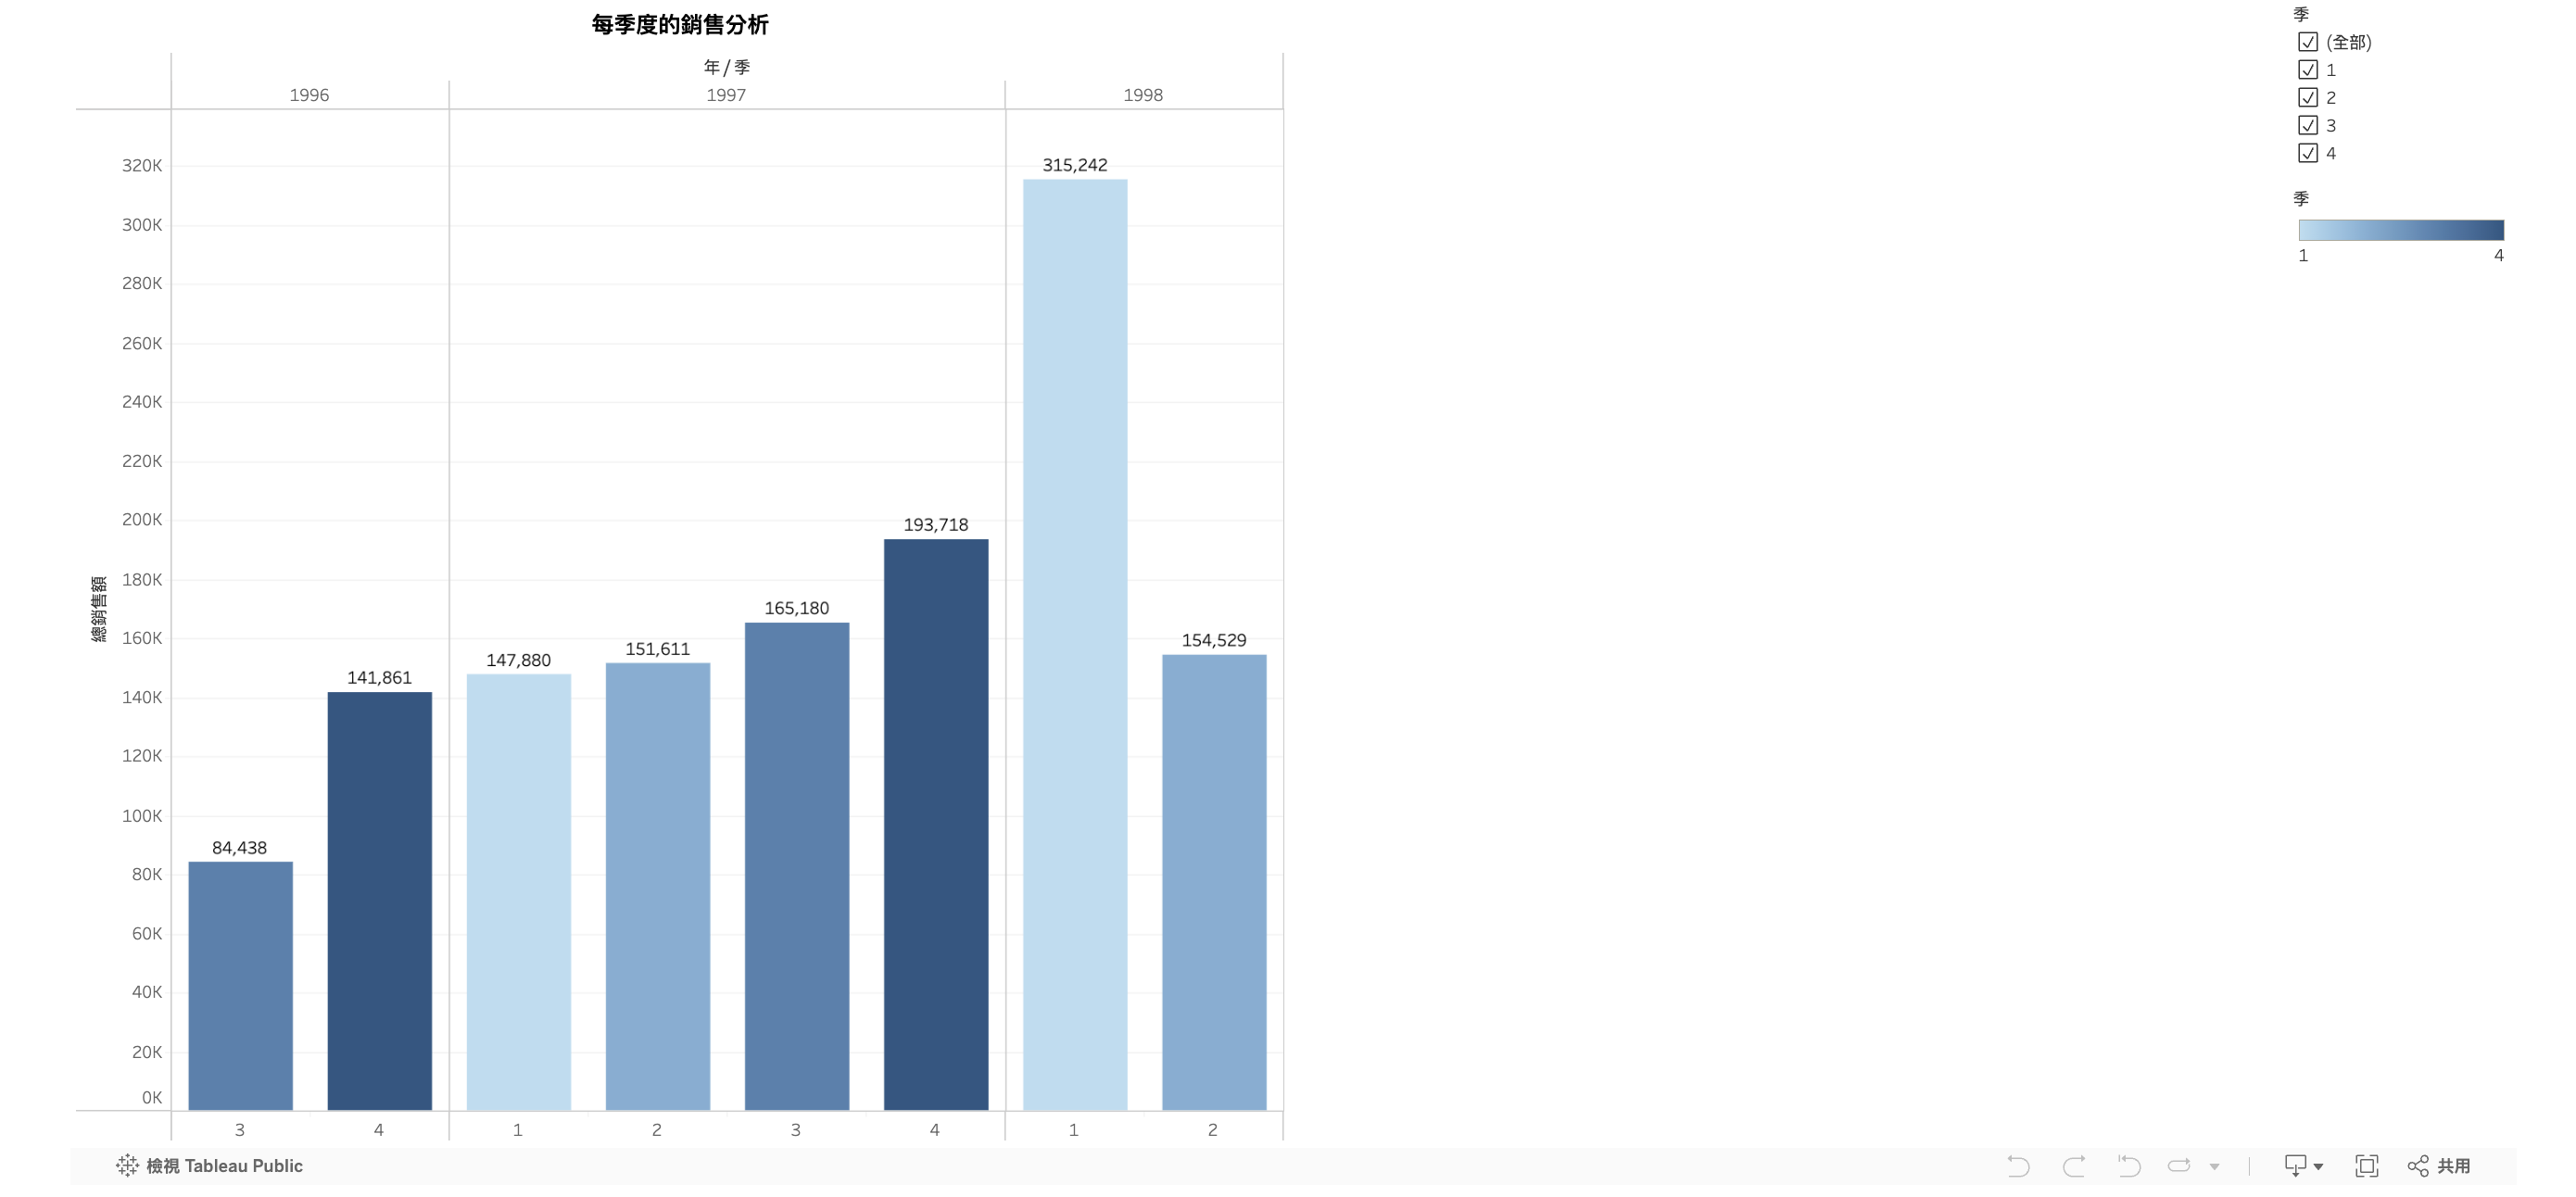

---
# **12. 找出所有訂單中還未發貨的訂單資料**
*沒有發貨，是因為ShippedDate欄位還沒有值（Null）

In [ ]:
sql = '''
select OrderID,
		CustomerID,
        OrderDate,
        ShippedDate
 from orders
where ShippedDate is null;
'''
df = pd.read_sql_query(sql, conn)
df

<ipython-input-13-1bf21a3b273f>:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,OrderID,CustomerID,OrderDate,ShippedDate
0,11008,ERNSH,1998-04-08,None
1,11019,RANCH,1998-04-13,None
2,11039,LINOD,1998-04-21,None
3,11040,GREAL,1998-04-22,None
4,11045,BOTTM,1998-04-23,None
5,11051,LAMAI,1998-04-27,None
6,11054,CACTU,1998-04-28,None
7,11058,BLAUS,1998-04-29,None
8,11059,RICAR,1998-04-29,None
9,11061,GREAL,1998-04-30,None
